In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [3]:
def points_for_boundary(X, clf):
    x_min, x_max = X.iloc[:, 0].agg(['min', 'max'])
    y_min, y_max = X.iloc[:, 1].agg(['min', 'max'])
    xs = np.linspace(x_min, x_max, 100)
    ys = np.linspace(y_min, y_max, 100)
    points = pd.DataFrame({
        'xs': np.tile(xs, len(ys)),
        'ys': np.repeat(ys, len(xs)),
    })
    return points.assign(pred=clf.predict(points))

In [4]:
def decision_boundary(X, y, clf):
    pred = points_for_boundary(X, clf)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, alpha=0.2, s=40,
                    legend=False)
    sns.scatterplot(X.iloc[:, 0], X.iloc[:, 1], hue=y,
                    s=60, legend=False)
    
    plt.subplot(122)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, s=40, legend=False)

## Bagging

In [276]:
from sklearn.datasets import make_moons, make_circles

X, y = make_circles(10000, noise=0.1, random_state=42)
data = pd.DataFrame(X, columns=['x1', 'x2']).assign(y=y)
data

,x1,x2,y
0,0.16,0.88,1
1,1.20,-0.54,0
2,-0.62,0.73,0
...,...,...,...
9997,0.64,0.36,1
9998,0.48,0.89,0
9999,-0.46,0.34,1


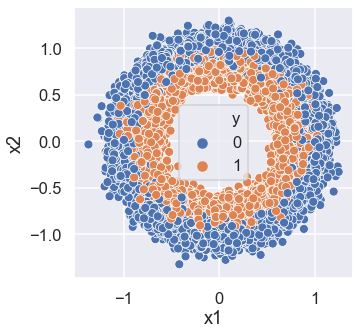

In [277]:
plt.figure(figsize=(5, 5))
sns.scatterplot('x1', 'x2', hue='y', data=data)

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data[['x1', 'x2']], data['y'], test_size=0.2, random_state=42)
X_train

,x1,x2
9254,2.39e-01,-1.07
1561,-2.60e-01,-0.94
1670,5.32e-01,0.50
...,...,...
5390,8.30e-03,0.66
860,5.18e-01,-0.66
7270,-9.12e-01,0.18


In [279]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

1.0

In [280]:
# Much worse!
tree.score(X_test, y_test)

0.7575

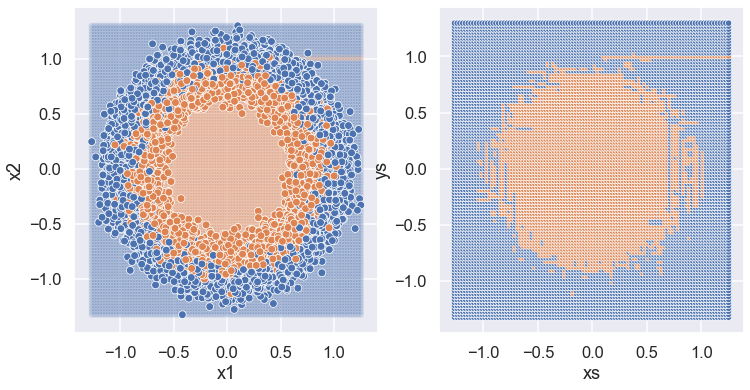

In [281]:
decision_boundary(X_train, y_train, tree)

In [282]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy'),
    n_estimators=100,
    n_jobs=4,
)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_train, y_train)

1.0

In [283]:
bagging_clf.score(X_test, y_test)

0.8025

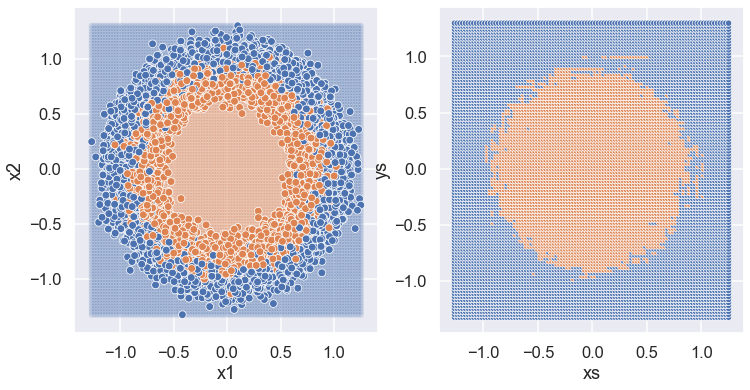

In [284]:
decision_boundary(X_train, y_train, bagging_clf)

## Random Forests

In [285]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=4,
                            criterion='entropy')
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

1.0

In [286]:
rf.score(X_test, y_test)

0.804

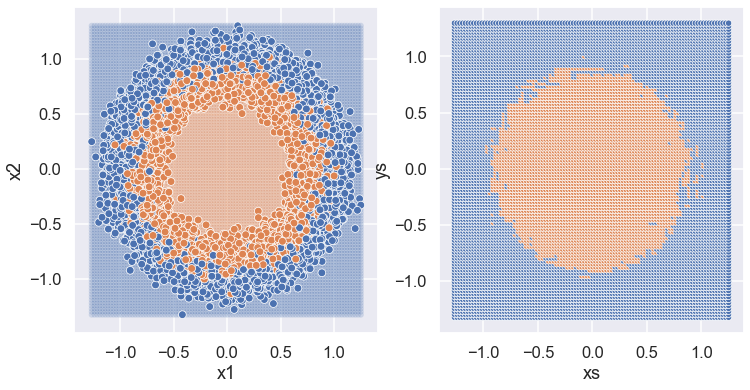

In [287]:
decision_boundary(X_train, y_train, rf)

Why doesn't the RF do better than a simple bagging classifier in this case?

### Image Classification

In [5]:
def flatten(arr): return [i for row in arr for i in row]

def display_digit(digit, ax=None):
    im = np.array(digit).reshape((28, 28))
    ax = sns.heatmap(im, cbar=None, xticklabels=[], yticklabels=[], cmap=sns.color_palette('Greys'), ax=ax)
    ax.set_aspect('equal')
    
def display_digits(digits):
    fig, axes = plt.subplots(2, 5, squeeze=False, figsize=(6, 3))
    for digit, ax in zip(digits.values, flatten(axes)):
        display_digit(digit, ax)

In [26]:
from scipy.io import loadmat

data = loadmat('mnist.mat')
X = pd.DataFrame(data['X'])
y = pd.Series(data['y'][0])

In [23]:
X

,0,1,2,3,...,780,781,782,783
0,0,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,0,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
997,0,0,0,0,...,0,0,0,0
998,0,0,0,0,...,0,0,0,0
999,0,0,0,0,...,0,0,0,0


In [29]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True)

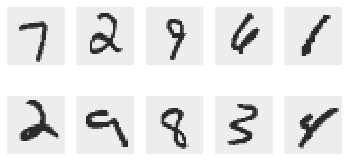

In [30]:
display_digits(X.iloc[::100])

In [31]:
%%time

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

/Users/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


CPU times: user 1.99 s, sys: 59.3 ms, total: 2.05 s
Wall time: 1.26 s


/Users/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [32]:
clf.score(X_train, y_train)

1.0

In [33]:
clf.score(X_test, y_test)

0.84

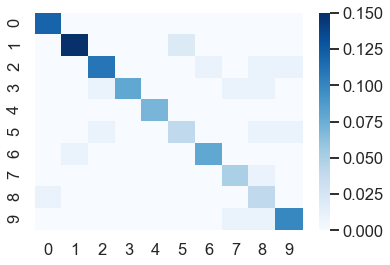

In [34]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, clf.predict(X_test)) / len(y_test)
sns.heatmap(conf, cmap='Blues')

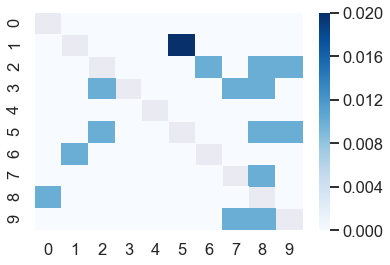

In [35]:
from sklearn.metrics import confusion_matrix

np.fill_diagonal(conf, np.nan)
sns.heatmap(conf, cmap='Blues')

In [38]:
%%time

forest = RandomForestClassifier(
    n_estimators=100, criterion='entropy', n_jobs=4)
forest.fit(X_train, y_train)

CPU times: user 872 ms, sys: 30.3 ms, total: 902 ms
Wall time: 398 ms


In [39]:
forest.score(X_train, y_train)

1.0

In [40]:
forest.score(X_test, y_test)

0.92

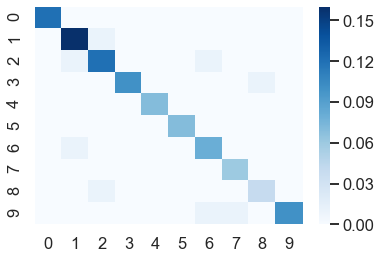

In [41]:
conf = confusion_matrix(y_test, forest.predict(X_test)) / len(y_test)
sns.heatmap(conf, cmap='Blues')

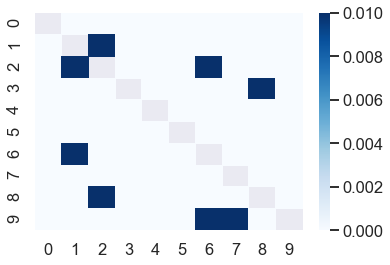

In [42]:
np.fill_diagonal(conf, np.nan)
sns.heatmap(conf, cmap='Blues')

## Runtime Considerations

In [245]:
%%timeit

n = 1_000_000

[i ** 2 for i in range(n)]

322 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [246]:
%%timeit

n = 2_000_000

[i ** 2 for i in range(n)]

661 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


numpy makes things run much faster but doesn't change how the runtime grows!

In [247]:
%%timeit

n = 1_000_000

np.arange(n) ** 2

3.26 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [248]:
%%timeit

n = 2_000_000

np.arange(n) ** 2

8.8 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
